# Using the expression of genes on the X-chromosome to predict young or aged cells (2/5 -- preprocessing and model tunning)

## Outline

The **Xgene** workflow consists of three sections:

I. Exploratory data analysis (EDA) (1/5)

II. preprocessing and model tunning (2/5, this notebook):

1. [Data preprocessing with KFold splitting](#1.-prepro)
2. [Model tunning](#2.-tunning)
    - [Lasso](#3.-l1)
    - [Ridge](#4.-l2)
    - [ElasticNet](#5.-eln)
    
    - [Random Forest](#6.-rfc)
    - [Support Vector Machine with rbf kernel](#7.-svc)
    - [XGBoost](#8.-xgbc)
    
    - [K Nearest Neighbor](#9.-knn)
    - [Naive Bayes](#10.-gnb)

III. Model comparison (3/5)

IV. Final model over 50 random states (4/5)

V. Results and intepretations (5/5)

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data preprocessing <a name="1.-prepro"></a>
### KFold Splitting -- the goal here is *not* to predict the cells from unseen animals. However, if we are interested in previously unseen animals,  we should use GroupKFold splitting to avoid data leakage.

- how you split the dataset and why: I want to predict whether the cell is young or aged based on the X-chromosome gene expression. So the target variable is 'young' denoted as 0, and 'aged' denoted as 1 in the dataset. The dataset has 8 animals, which is too small for GroupKFold splitting. To clarify, let's predict the cells within the 8 animals for now.

- Is your dataset IID? Yes. Cells are independent of each other and their features have similar distributions.


- Does it have group structure? No, cells are independent from each other.


- Is it a time-series data? No, it's not.


- How should you split the dataset given your ML question to best mimic future use when you deploy the model? I expect to see a similar uncertainty when the model gets deployed, so I will try to change the random state for several times (10 times) to access how much the random split affects my test result. I will also avoid to use information in validation or test set when deploying the model (only fit_transform the training set).


- StandardScaler on the continuous features (e.g. gene expression). Because based on the histogram, the distribution of the expression is very zero inflated. So StandardScaler should perform better than the MinMaxScaler


- Apply OneHotEncoder on categorical features (cell types/ tree.ident). Because the category is not ordinal.


- How many features do you have in the preprocessed data? 282 features. However, there're features that I am more interested in: ['Xist', 'Tsix', 'Ftx', '5330434G04Rik','Pak3', 'Pcsk1n', 'Pgrmc1', 'x_sum', 'x:a'], and these features of interest are also shown in the scatter matrix.


In [3]:
merged_features = pd.read_csv('snhypo_neuron_x_12.csv', index_col=0)
features = list(merged_features.columns)
features.remove('target')
features.remove('group')

In [5]:
y = merged_features['target']

X = merged_features[features]
group = merged_features['group']
# gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42) # 0.2 for test

X.head()

,tree.ident,Gm26618,Clcn5,Syp,Gm14703,Gpkow,Praf2,Gripap1,Otud5,Pim2,...,Ofd1,Tmsb4x,Frmpd4,Arhgap6,Gm15261,Gm15246,Mid1,sum,x_sum,x_prop
AAACCTGAGACTAGAT-1_1,Avp/Oxt,0.0,1.041756,1.872197,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,1.041756,1.041756,2.319535,0.000000,0.0,0.0,0.000000,3477.047641,128.435941,0.036938
AAACCTGAGGCCCGTT-1_1,Nrg1/Nnat,0.0,0.000000,1.751268,0.0,0.000000,0.0,0.000000,0.0,1.751268,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2213.750159,74.358735,0.033589
AAACCTGCAGCATGAG-1_1,Meis2/Pou6f2,0.0,0.000000,1.795519,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,1.795519,2.144047,0.000000,0.0,0.0,0.000000,3115.133693,136.693263,0.043880
AAACCTGGTCCGTGAC-1_1,Npas3/Gm32647,0.0,0.000000,0.000000,0.0,1.338608,0.0,0.000000,0.0,0.000000,...,0.000000,1.891222,0.000000,0.000000,0.0,0.0,0.000000,3213.846256,112.650185,0.035052
AAACCTGTCGATGAGG-1_1,Chrm3/Schip1,0.0,0.000000,1.073143,0.0,0.000000,0.0,1.073143,0.0,1.073143,...,0.000000,1.073143,1.578796,1.073143,0.0,0.0,1.073143,3602.011572,130.895194,0.036339


In [6]:
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle

In [7]:
cat_ftrs = ['tree.ident']

features = list(merged_features.columns)
features.remove('target')
features.remove('group')
cont_ftrs = features[1:-1]

In [8]:
def ML_pipeline_GridSearchCV(X, y, groups, clf, param_grid, random_state, n_folds, xgbc=False, set_random=True):
    '''
    clf: classifier
    param_grid: parameter grid
    '''
    # create a test set based on groups
    random_state = 42*random_state
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    # onehotencoder for the categorical feature -- tree.ident
 
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

    # standard scaler for continuous feature
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])

    
    if xgbc:
        clf.set_params(seed=random_state)
    if set_random:
        clf.set_params(random_state=random_state)
        
    # create the pipeline: preprocessor + supervised ML method
    pipe = make_pipeline(preprocessor, clf)
    
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring=make_scorer(accuracy_score),
                        cv=kf, return_train_score=True, n_jobs=-1)
    
    # do kfold CV on _other
    grid.fit(X_other, y_other)

    return grid, grid.score(X_test, y_test)

## 2. Model tunning<a name="2.-tunning"></a>

### 1) Logistic regression -- l1<a name="3.-l1"></a>

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
l1 = LogisticRegression(penalty='l1', solver='saga', max_iter=10000000)
param_grid = {'logisticregression__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

models_l1 = []
for i in range(10):
    grid, test_score = ML_pipeline_GridSearchCV(X, y, group, l1, param_grid, i, 5)
    print(grid.best_params_)
    print('best CV score:', grid.best_score_)
    print('test score:',test_score)
    models_l1.append(grid)

file = open('./results/5fold_l1_models_10_finer.save', 'wb')
pickle.dump(models_l1, file)
file.close()

{'logisticregression__C': 0.1}
best CV score: 0.7304631467133217
test score: 0.7376524695060988
{'logisticregression__C': 0.1}
best CV score: 0.7296127468132967
test score: 0.7408518296340731
{'logisticregression__C': 0.1}
best CV score: 0.7317633591602098
test score: 0.7306538692261547
{'logisticregression__C': 0.5}
best CV score: 0.7316135091227194
test score: 0.7248550289942012
{'logisticregression__C': 1}
best CV score: 0.7326632716820796
test score: 0.7316536692661467
{'logisticregression__C': 1}
best CV score: 0.7314131592101976
test score: 0.732253549290142
{'logisticregression__C': 0.5}
best CV score: 0.7267135466133466
test score: 0.7420515896820636
{'logisticregression__C': 1}
best CV score: 0.7270135341164708
test score: 0.7344531093781244
{'logisticregression__C': 10}
best CV score: 0.7341137215696076
test score: 0.7286542691461708
{'logisticregression__C': 0.1}
best CV score: 0.7309135716070984
test score: 0.7226554689062188


### 2) Logistic regression -- l2<a name="4.-l2"></a>

In [11]:
l2 = LogisticRegression(penalty='l2', solver='saga', max_iter=10000000)
param_grid = {'logisticregression__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

models_l2 = []
for i in range(10):
    grid, test_score = ML_pipeline_GridSearchCV(X, y, group, l2, param_grid, i, 5)
    print(grid.best_params_)
    print('best CV score:', grid.best_score_)
    print('test score:',test_score)
    models_l2.append(grid)
file = open('./results/5fold_l2_models_10_finer.save', 'wb')
pickle.dump(models_l2, file)
file.close()

{'logisticregression__C': 1}
best CV score: 0.7301134341414646
test score: 0.7348530293941212
{'logisticregression__C': 0.1}
best CV score: 0.7290127218195451
test score: 0.7420515896820636
{'logisticregression__C': 0.1}
best CV score: 0.7316633841539615
test score: 0.734253149370126
{'logisticregression__C': 0.1}
best CV score: 0.7320134841289677
test score: 0.7268546290741852
{'logisticregression__C': 0.5}
best CV score: 0.733163246688328
test score: 0.7318536292741452
{'logisticregression__C': 0.5}
best CV score: 0.7316131967008247
test score: 0.7326534693061387
{'logisticregression__C': 10}
best CV score: 0.7260635966008497
test score: 0.74125174965007
{'logisticregression__C': 1}
best CV score: 0.7273635341164709
test score: 0.734253149370126
{'logisticregression__C': 10}
best CV score: 0.7342137215696077
test score: 0.7286542691461708
{'logisticregression__C': 0.5}
best CV score: 0.7306637215696077
test score: 0.7220555888822235


### 3) Logistic regression -- ElasticNet<a name="5.-eln"></a>

In [12]:
eln = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000000)
param_grid = {'logisticregression__C': [0.05, 0.1, 0.5, 1, 3],
             'logisticregression__l1_ratio': [0.2, 0.35, 0.5, 0.65, 0.8]}

models_eln = []
for i in range(10):
    grid, test_score = ML_pipeline_GridSearchCV(X, y, group, eln, param_grid, i, 5)
    print(grid.best_params_)
    print('best CV score:', grid.best_score_)
    print('test score:',test_score)
    models_eln.append(grid)
    
file = open('./results/5fold_eln_models_10_finer.save', 'wb')
pickle.dump(models_eln, file)
file.close()

{'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.65}
best CV score: 0.7308132466883279
test score: 0.73625274945011
{'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.5}
best CV score: 0.730662671832042
test score: 0.7426514697060588
{'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.8}
best CV score: 0.7319633716570857
test score: 0.7308538292341532
{'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.2}
best CV score: 0.7322134841289676
test score: 0.7276544691061788
{'logisticregression__C': 1, 'logisticregression__l1_ratio': 0.35}
best CV score: 0.7328632591852038
test score: 0.7314537092581483
{'logisticregression__C': 1, 'logisticregression__l1_ratio': 0.5}
best CV score: 0.731763184203949
test score: 0.732253549290142
{'logisticregression__C': 0.5, 'logisticregression__l1_ratio': 0.8}
best CV score: 0.7266635466133466
test score: 0.742251549690062
{'logisticregression__C': 1, 'logisticregression__l1_ratio': 0.5}
best CV sco

### 4) Random Forest Classifier<a name="6.-rfc"></a>

In [15]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

In [16]:
rfc = RandomForestClassifier()
param_grid = {'randomforestclassifier__max_features': [25, 50, 75, 100, 200, None],
              'randomforestclassifier__max_depth': [10, 20, 30, 50, 100, None],
              'randomforestclassifier__min_samples_split': [2, 5, 10, 20]}

models_rfc = []
for i in tqdm(range(10)):
    grid, test_score = ML_pipeline_GridSearchCV(X, y, group, rfc, param_grid, i, 5)
    print(grid.best_params_)
    print('best CV score:', grid.best_score_)
    print('test score:',test_score)
    models_rfc.append(grid)
    
import pickle
file = open('./results/rfc_models_finer.save', 'wb')
pickle.dump(models_rfc, file)
file.close()

 10%|█         | 1/10 [1:11:42<10:45:24, 4302.73s/it]

{'randomforestclassifier__max_depth': 100, 'randomforestclassifier__max_features': 100, 'randomforestclassifier__min_samples_split': 2}
best CV score: 0.757812046988253
test score: 0.7742451509698061


 20%|██        | 2/10 [2:09:00<8:25:51, 3793.91s/it] 

{'randomforestclassifier__max_depth': 100, 'randomforestclassifier__max_features': 200, 'randomforestclassifier__min_samples_split': 10}
best CV score: 0.7585109472631842
test score: 0.768246350729854


 30%|███       | 3/10 [3:24:56<8:03:14, 4142.12s/it]

{'randomforestclassifier__max_depth': 30, 'randomforestclassifier__max_features': 50, 'randomforestclassifier__min_samples_split': 10}
best CV score: 0.7611617845538616
test score: 0.7626474705058989


 40%|████      | 4/10 [4:42:13<7:13:44, 4337.42s/it]

{'randomforestclassifier__max_depth': 100, 'randomforestclassifier__max_features': 100, 'randomforestclassifier__min_samples_split': 10}
best CV score: 0.7623120719820045
test score: 0.7494501099780044


 50%|█████     | 5/10 [5:29:00<5:15:28, 3785.61s/it]

{'randomforestclassifier__max_depth': 30, 'randomforestclassifier__max_features': 75, 'randomforestclassifier__min_samples_split': 10}
best CV score: 0.7612619095226194
test score: 0.7590481903619276


 60%|██████    | 6/10 [6:16:09<3:50:41, 3460.28s/it]

{'randomforestclassifier__max_depth': 30, 'randomforestclassifier__max_features': 75, 'randomforestclassifier__min_samples_split': 20}
best CV score: 0.7612620344913772
test score: 0.765246950609878


 70%|███████   | 7/10 [6:55:01<2:34:33, 3091.18s/it]

{'randomforestclassifier__max_depth': 30, 'randomforestclassifier__max_features': 200, 'randomforestclassifier__min_samples_split': 5}
best CV score: 0.7608116595851037
test score: 0.7600479904019196


 80%|████████  | 8/10 [7:47:20<1:43:33, 3106.68s/it]

{'randomforestclassifier__max_depth': 50, 'randomforestclassifier__max_features': 200, 'randomforestclassifier__min_samples_split': 2}
best CV score: 0.7597118970257436
test score: 0.7630473905218956


 90%|█████████ | 9/10 [8:16:41<44:45, 2685.75s/it]  

{'randomforestclassifier__max_depth': 100, 'randomforestclassifier__max_features': 200, 'randomforestclassifier__min_samples_split': 20}
best CV score: 0.7617622719320171
test score: 0.757248550289942


100%|██████████| 10/10 [8:43:12<00:00, 3139.22s/it]

{'randomforestclassifier__max_depth': 30, 'randomforestclassifier__max_features': 75, 'randomforestclassifier__min_samples_split': 20}
best CV score: 0.7614122219445139
test score: 0.7486502699460108


### 5) SVC<a name="7.-svc"></a>

In [17]:
from sklearn.svm import SVC
svc = SVC()
param_grid = {'svc__gamma': [1e-4, 1e-3, 1e-2, 1e-1],
              'svc__C': np.logspace(-1, 1, 5)}

models_svc = []
for i in tqdm(range(10)):
    grid, test_score = ML_pipeline_GridSearchCV(X, y, group, svc, param_grid, i, 5)
    print(grid.best_params_)
    print('best CV score:', grid.best_score_)
    print('test score:',test_score)
    models_svc.append(grid)
    
import pickle
file = open('./results/svc_models_finer.save', 'wb')
pickle.dump(models_svc, file)
file.close()

Image was attached because results were obtained in the other notebooks.
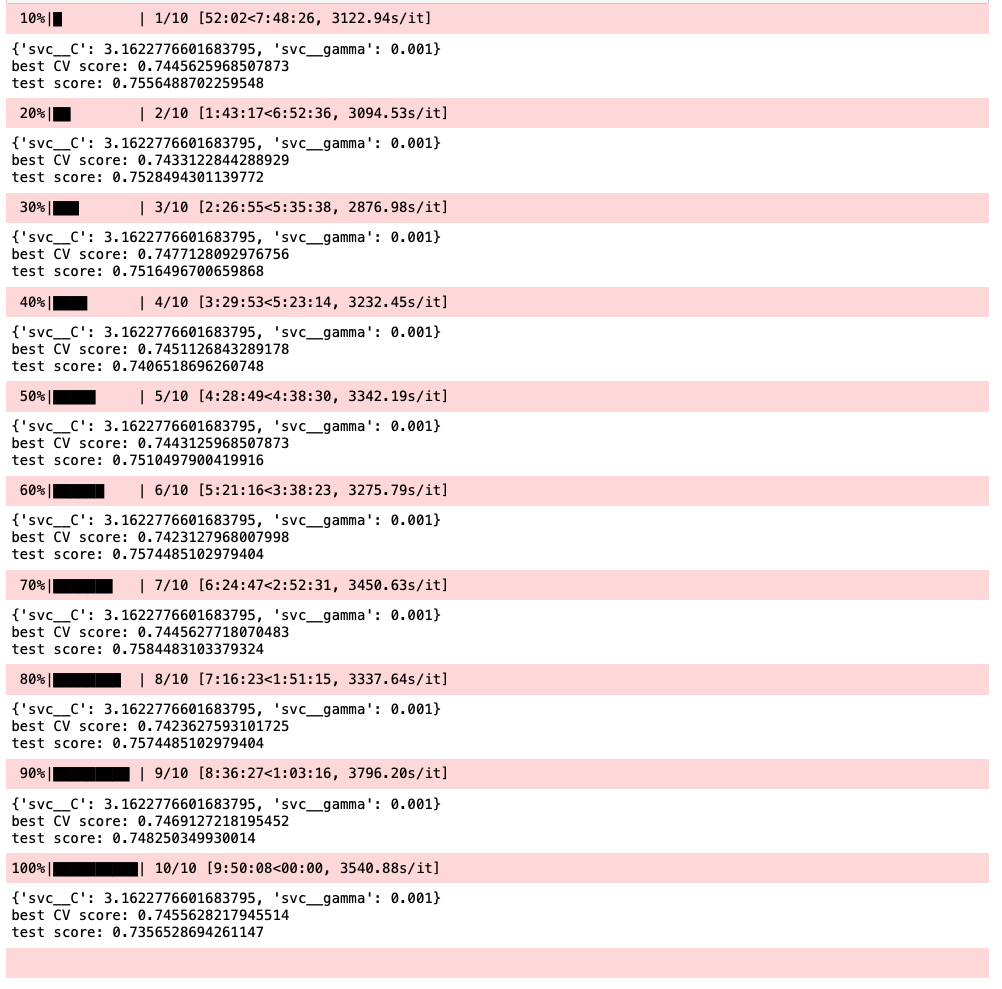

### 6) XGBoost Classifier<a name="8.-xgbc"></a>

In [18]:
import xgboost
from xgboost import XGBClassifier

xgbc = XGBClassifier(use_label_encoder=False)
param_grid = {'xgbclassifier__max_depth': [1, 3, 5, 10, 20, 30, 100],
              "xgbclassifier__learning_rate": [0.03],
              #'xgbclassifier__min_child_weight': [1, 3, 5, 7],
              #'xgbclassifier__gamma': [0, 0.1, 0.2 , 0.3, 0.4],
              'xgbclassifier__colsample_bytree': [0.9],
              'xgbclassifier__subsample': [0.66],
              'xgbclassifier__eval_metric': ['logloss']}

models_xgbc = []
for i in tqdm(range(10)):
    grid, test_score = ML_pipeline_GridSearchCV(X, y, group, xgbc, param_grid, i, 5, xgbc=True)
    print(grid.best_params_)
    print('best CV score:', grid.best_score_)
    print('test score:',test_score)
    models_xgbc.append(grid)

import pickle
file = open('./results/xgbc_models_combined.save', 'wb')
pickle.dump(models_xgbc, file)
file.close()

### 7) KNN<a name="9.-knn"></a>

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param_grid = {'kneighborsclassifier__n_neighbors': [30, 100, 200, 300],
              'kneighborsclassifier__weights': ['uniform', 'distance']}

models_knn = []
for i in range(10):
    grid, test_score = ML_pipeline_GridSearchCV(X, y, group, knn, param_grid, i, 5, set_random=False)
    print(grid.best_params_)
    print('best CV score:', grid.best_score_)
    print('test score:',test_score)
    models_knn.append(grid)

file = open('./results/5fold_knn_models_10.save', 'wb')
pickle.dump(models_knn, file)
file.close()

### 8) Naive Bayes<a name="10.-gnb"></a>

In [22]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
param_grid = {}

models_gnb = []
for i in range(10):
    grid, test_score = ML_pipeline_GridSearchCV(X, y, group, gnb, param_grid, i, 5, set_random=False)
    print(grid.best_params_)
    print('best CV score:', grid.best_score_)
    print('test score:',test_score)
    models_gnb.append(grid)
    
file = open('./results/5fold_gnb_models_10.save', 'wb')
pickle.dump(models_gnb, file)
file.close()

{}
best CV score: 0.6403178580354911
test score: 0.646870625874825
{}
best CV score: 0.62786792051987
test score: 0.640871825634873
{}
best CV score: 0.6426175456135965
test score: 0.652869426114777
{}
best CV score: 0.638918045488628
test score: 0.637872425514897
{}
best CV score: 0.6449168832791802
test score: 0.620875824835033
{}
best CV score: 0.6448677705573607
test score: 0.6412717456508699
{}
best CV score: 0.639567470632342
test score: 0.6560687862427514
{}
best CV score: 0.6367679705073731
test score: 0.6490701859628074
{}
best CV score: 0.6437682829292678
test score: 0.6412717456508699
{}
best CV score: 0.6281185328667833
test score: 0.6192761447710458


In [23]:
# save the test_sets
test_sets = []
for i in range(10):
        
    random_state = 42*i
        
    # since the same random states are used for all models, 
    # we can recapitulate the test sets in individual state and check accuracies
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    
    test_sets.append((X_test, y_test))

import pickle
file = open('./data/test_sets.save', 'wb')
pickle.dump((test_sets),file)
file.close()